# Cost curve figures

Here I take IPCC AR6 WGIII data on mitigation costs and formulate the "no free lunches" version of the MACC, a sensitivity test to the critique that negative/close to zero abatement costs, while potentially true at the engineering level, are not feasible at the macroeconomic level.

In [1]:
import sys
import datetime

import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
import seaborn as sns
import xarray as xr

# plotting parameters
color_list = ['#000000', '#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7'] * 2
marker_list = ['o', 's', 'P', '+', 'D', 'v', '3', 'm'] * 2
markersize = 6
linestyle_list = ['solid', 'dashed', 'dashdot', 'dotted'] * 4
linewidth = 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
cdds_params={'axes.linewidth': 3,
 'axes.axisbelow': False,
 'axes.edgecolor': 'black',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'black',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'axes.titlesize': 20,
 'axes.labelsize': 20,
 'axes.titlelocation': 'left',
 'figure.facecolor': 'white',
 'figure.figsize': (18, 10),
 'lines.solid_capstyle': 'round',
 'lines.linewidth': 2.5,
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'black',
 'legend.frameon': False,
 'xtick.bottom': True,
 'xtick.major.width': 3,
 'xtick.major.size': 6,
 'xtick.color': 'black',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'black',
 'ytick.direction': 'out',
 'ytick.left': True,
 'ytick.right': False,
 'ytick.color' : 'black',
 'ytick.major.width': 3, 
 'ytick.major.size': 6,
 'axes.prop_cycle': plt.cycler(color=color_list, linestyle=linestyle_list),
 'font.size': 16,
 'font.family': 'serif'}
plt.rcParams.update(cdds_params)

# make base filename
today = datetime.datetime.now()
year = str(today.year)
day = str(today.day)
month = str(today.month)

basefile = ''.join(["/data/keeling/a/adammb4/ClimateEcon/ez-climate/TCREZClimate/docs/figdump/", month, '-', day, '-', year, '-'])

## Setup data

The strategy of making this figure is the following. The _x_-axis is the mitigation potential (in GtCO$_2$) and the _y_-axis is the cost. The width of a given bar is the mitigation potential, its height is the cost.

The IPCC only gives _ranges_ of cost per method of abatement. This is slightly annoying for the modeler who needs deterministic costs. We just choose the upper bound of each range as the cost of a given method. This way, the resulting curve fit can truly be considered a "worst case" for abatement costs; in the real world, costs will be (slightly) lower. 

**In the below, the first two entries are added to shift the near-zero costs over to being 20 dollar costs.**

In [2]:
# Taken from provided spreadsheet of IPCC WGIII data, see directory that contains this notebook.

cost_data = {
    'Wind energy': [2.31, 0.77, 0.77, 0, 0],
    'Solar energy': [2.7, 0.6, 0.6, 0.6, 0],
    'Nuclear energy': [0.176] * 5,
    'Bioelectricity': [0, 0, 0, 0.43, 0.43],
    'Hydropower': [0, 0.11, 0.11, 0.11, 0],
    'Geothermal energy': [0, 0.25, 0.25, 0.25, 0],
    'Carbon capture and storage (CCS)': [0,0,0,0.27,0.27],
    'Biolectricity with CCS': [0, 0, 0, 0.15, 0.15],
    'Reduce CH$_4$ emissions from coal mining': [0.04, 0.41, 0.03, 0.02, 0],
    'Reduce CH$_4$ emissions from oil and gas': [0.31, 0.61, 0.07, 0.06, 0.1],
    'Carbon sequestration in agriculture': [0, 0.5, 0.73, 2.21, 0],
    'Reduce CH$_4$ and N$_2$O emission in agriculture': [0, 0.35, 0, 0.28, 0],
    'Reduce converstion of natural ecosystems': [0, 2.28, 0.12, 1.63, 0],
    'Restoration, afforestation, reforestation': [0, 0.15, 0.57, 1.46, 0.66],
    'Forest management, fire management': [0, 0.38, 0, 0.78, 0.22],
    'Avoid demand for energy services': [0.56, 0,0,0,0],
    'Efficient lighting, appliances and equipment': [0.73, 0,0,0,0],
    'New buildings with\nhigh energy performance': [0, 0.12, 0.12, 0.12, 0.83],
    'Onsite renewable\nproduction and use': [0, 0.07, 0.07, 0.07, 0.27],
    'Improvement of existing building stock': [0,0.07, 0.07, 0.07, 0.07],
    'Fuel efficient light duty vehicles': [0.56, 0, 0, 0, 0],
    'Shift to public transportation': [0.53, 0, 0, 0, 0],
    'Shift to bikes and e-bikes': [0.19, 0, 0, 0, 0],
    'Fuel efficient heavy duty vehicles': [0.36, 0, 0, 0, 0],
    'Shipping-efficiency and optimization': [0.47, 0, 0, 0, 0],
    'Aviation energy efficiency': [0.22, 0, 0, 0, 0],
    'Biofuels': [0, 0.23, 0.23, 0.23, 0],
    'Energy efficiency': [0, 1.14, 0, 0, 0],
    'Material efficiency': [0, 0, 0.93, 0, 0],
    'Enhanced recycling': [0, 0, 0.48, 0, 0],
    'Fuel switching': [0, 0, 1.28, 0.67, 0.15],
    'Feedstock decarbonization, process change': [0, 0, 0, 0.38, 0],
    'Carbon capture with\nutilization and storage': [0, 0, 0, 0, 0.15],
    'Cementious material substitution': [0, 0, 0.28, 0,0],
    'Reduction of non-CO$_2$ emissions': [0, 0.2, 0, 0, 0],
    'Reduce emission of fluorinated gas': [0.26, 0.68, 0.18, 0.09, 0.03],
    'Reduce CH$_4$ emission from solid waste': [0.33, 0.11, 0.06, 0.04, 0.08],
    'Reduce CH$_4$ emission\nfrom wastewater': [0.02, 0.03, 0.04, 0.03, 0.07]
}

In [3]:
# extra dictionary that keeps track if the given option has a label in the McKinsey-style bar chart below
def reset_label_tracker():
    label_tracker = {
    'Wind energy': False,
    'Solar energy': False,
    'Nuclear energy': False,
    'Bioelectricity': False,
    'Hydropower': False,
    'Geothermal energy': False,
    'Carbon capture and storage (CCS)': False,
    'Biolectricity with CCS': False,
    'Reduce CH$_4$ emissions from coal mining': False,
    'Reduce CH$_4$ emissions from oil and gas': False,
    'Carbon sequestration in agriculture': False,
    'Reduce CH$_4$ and N$_2$O emission in agriculture': False,
    'Reduce converstion of natural ecosystems':False,
    'Restoration, afforestation, reforestation': False,
    'Forest management, fire management': False,
    'Avoid demand for energy services': False,
    'Efficient lighting, appliances and equipment': False,
    'New buildings with\nhigh energy performance': False,
    'Onsite renewable\nproduction and use': False,
    'Improvement of existing building stock': False,
    'Fuel efficient light duty vehicles': False,
    'Shift to public transportation': False,
    'Shift to bikes and e-bikes': False,
    'Fuel efficient heavy duty vehicles': False,
    'Shipping-efficiency and optimization': False,
    'Aviation energy efficiency': False,
    'Biofuels': False,
    'Energy efficiency': False,
    'Material efficiency': False,
    'Enhanced recycling': False,
    'Fuel switching':False,
    'Feedstock decarbonization, process change': False,
    'Carbon capture with\nutilization and storage': False,
    'Cementious material substitution': False,
    'Reduction of non-CO$_2$ emissions': False,
    'Reduce emission of fluorinated gas': False,
    'Reduce CH$_4$ emission from solid waste': False,
    'Reduce CH$_4$ emission\nfrom wastewater': False
    }
    return label_tracker

## Perform curve fit

Since the IPCC gives ranges of prices and we assume the price is the maximum in the range, many methods of abatement have the same price. This makes fitting a curve tricky. We put a point at the beginning of the abatement range for a given price and fit a power law to the data to find $A$ and $B$ in,
 $$
\tau(x) = A x^B.
$$

After some work, I found that an exponential fit is probably better, as it grows faster for high abatement potentials than a power law. This is argued to be techically correct in the abatement cost literature, especially given that abatement potential in the 50s of GtCO$_2$-eq is probably out of reach at present and would be very costly to achieve. So here is the equation for the exponential fit:
$$
\tau(x) = A (e^{B x} - 1)
$$
where the exponential is offset by unity to satisfy the condition $\tau(x = 0) = 0$.

In [4]:
# find total mitigation in each range
tot_mit_bycost = np.zeros(5) # zero mitigation potential in each cost bracket
for key in cost_data:
    tot_mit_bycost += cost_data[key]

# shift total mitigation amounts to half after the zero cost methods
tot_mit_bycost[1:] = tot_mit_bycost[1:] * 1.1

# define accumluated mitigation potential
accumulated_mit_pot = np.zeros_like(tot_mit_bycost, dtype=float)

# sum over mitigations
for i in range(1, np.shape(tot_mit_bycost)[0]):
    accumulated_mit_pot[i] = np.sum(tot_mit_bycost[:i])
    
print(tot_mit_bycost, accumulated_mit_pot)
costs = np.array([20, 50, 100, 200, 400])

[ 9.766  10.1596  7.8826 11.1386  4.0216] [ 0.      9.766  19.9256 27.8082 38.9468]


### Power law

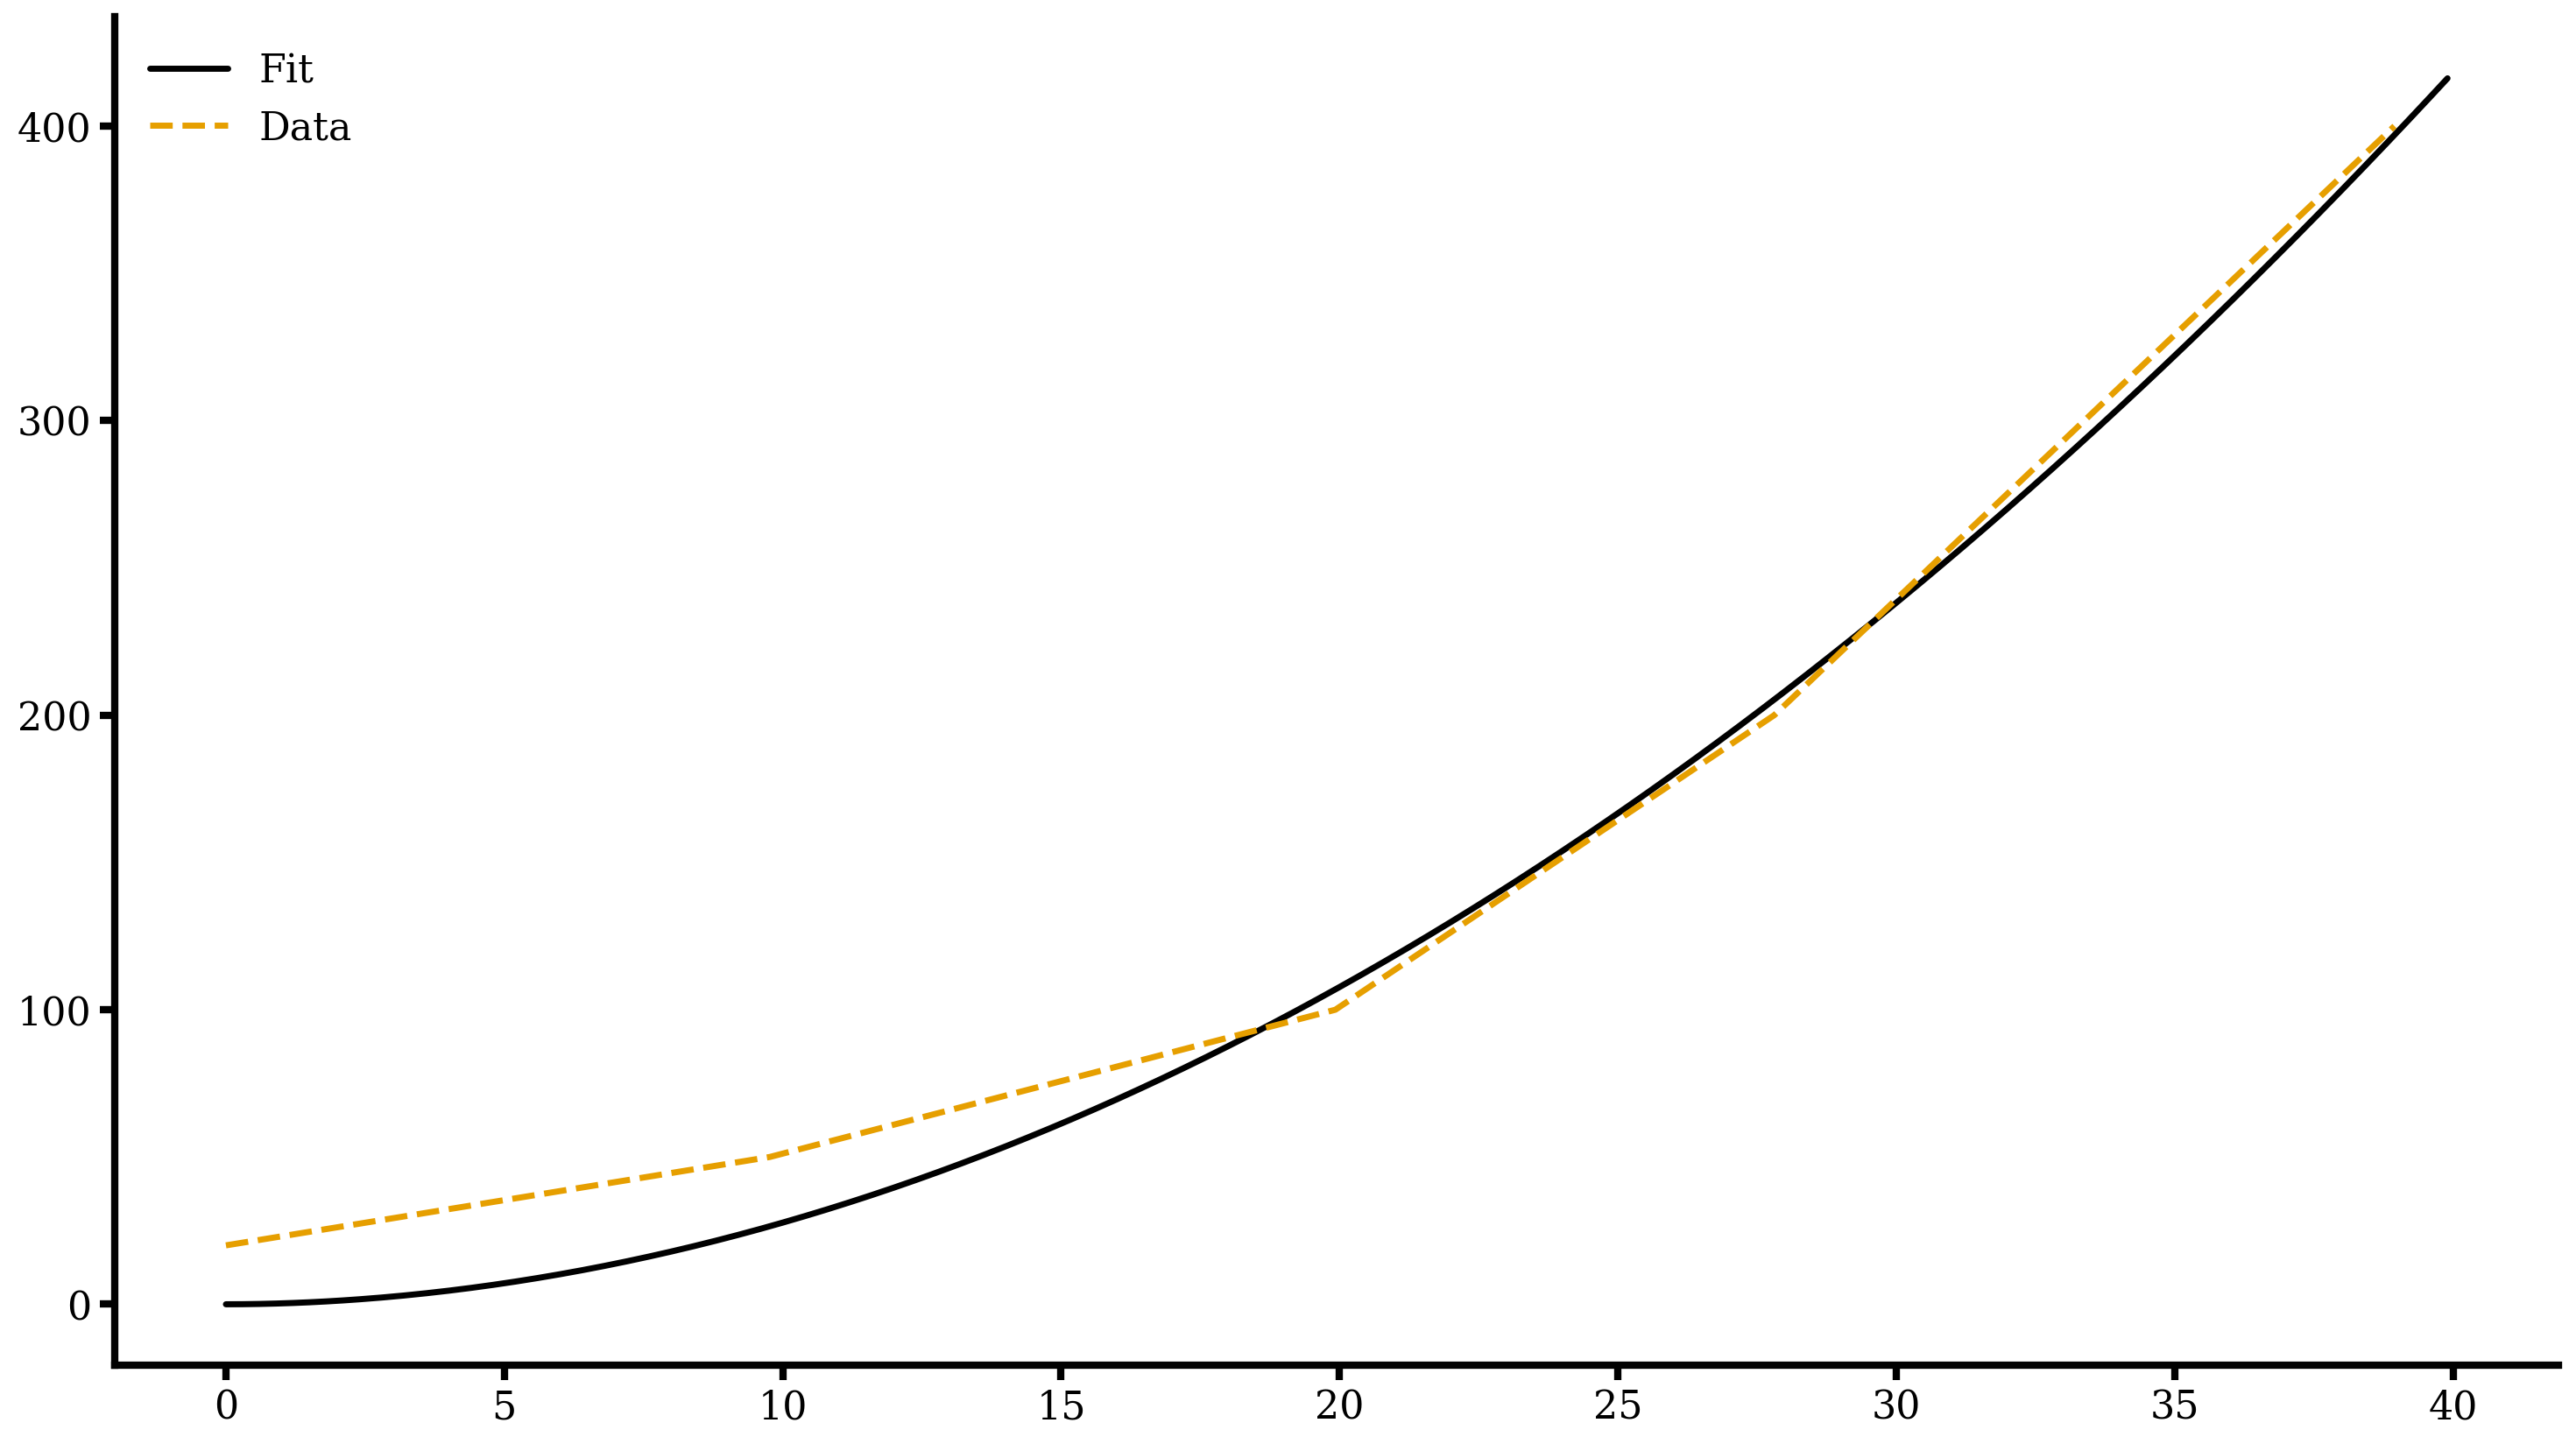

In [5]:
from scipy.optimize import curve_fit

# perform curve fit
def f(x, a, b):
    return a * x**b

opt_fit = curve_fit(f, accumulated_mit_pot, costs)

# extract coefficient and power, respectively
a,b = opt_fit[0]

# check plot
x_accumulated_pot = np.arange(0, 40, 0.1)
plt.plot(x_accumulated_pot, a * x_accumulated_pot**b, label="Fit") # fit
plt.plot(accumulated_mit_pot, costs, label="Data") # data
plt.legend()

### Exponential

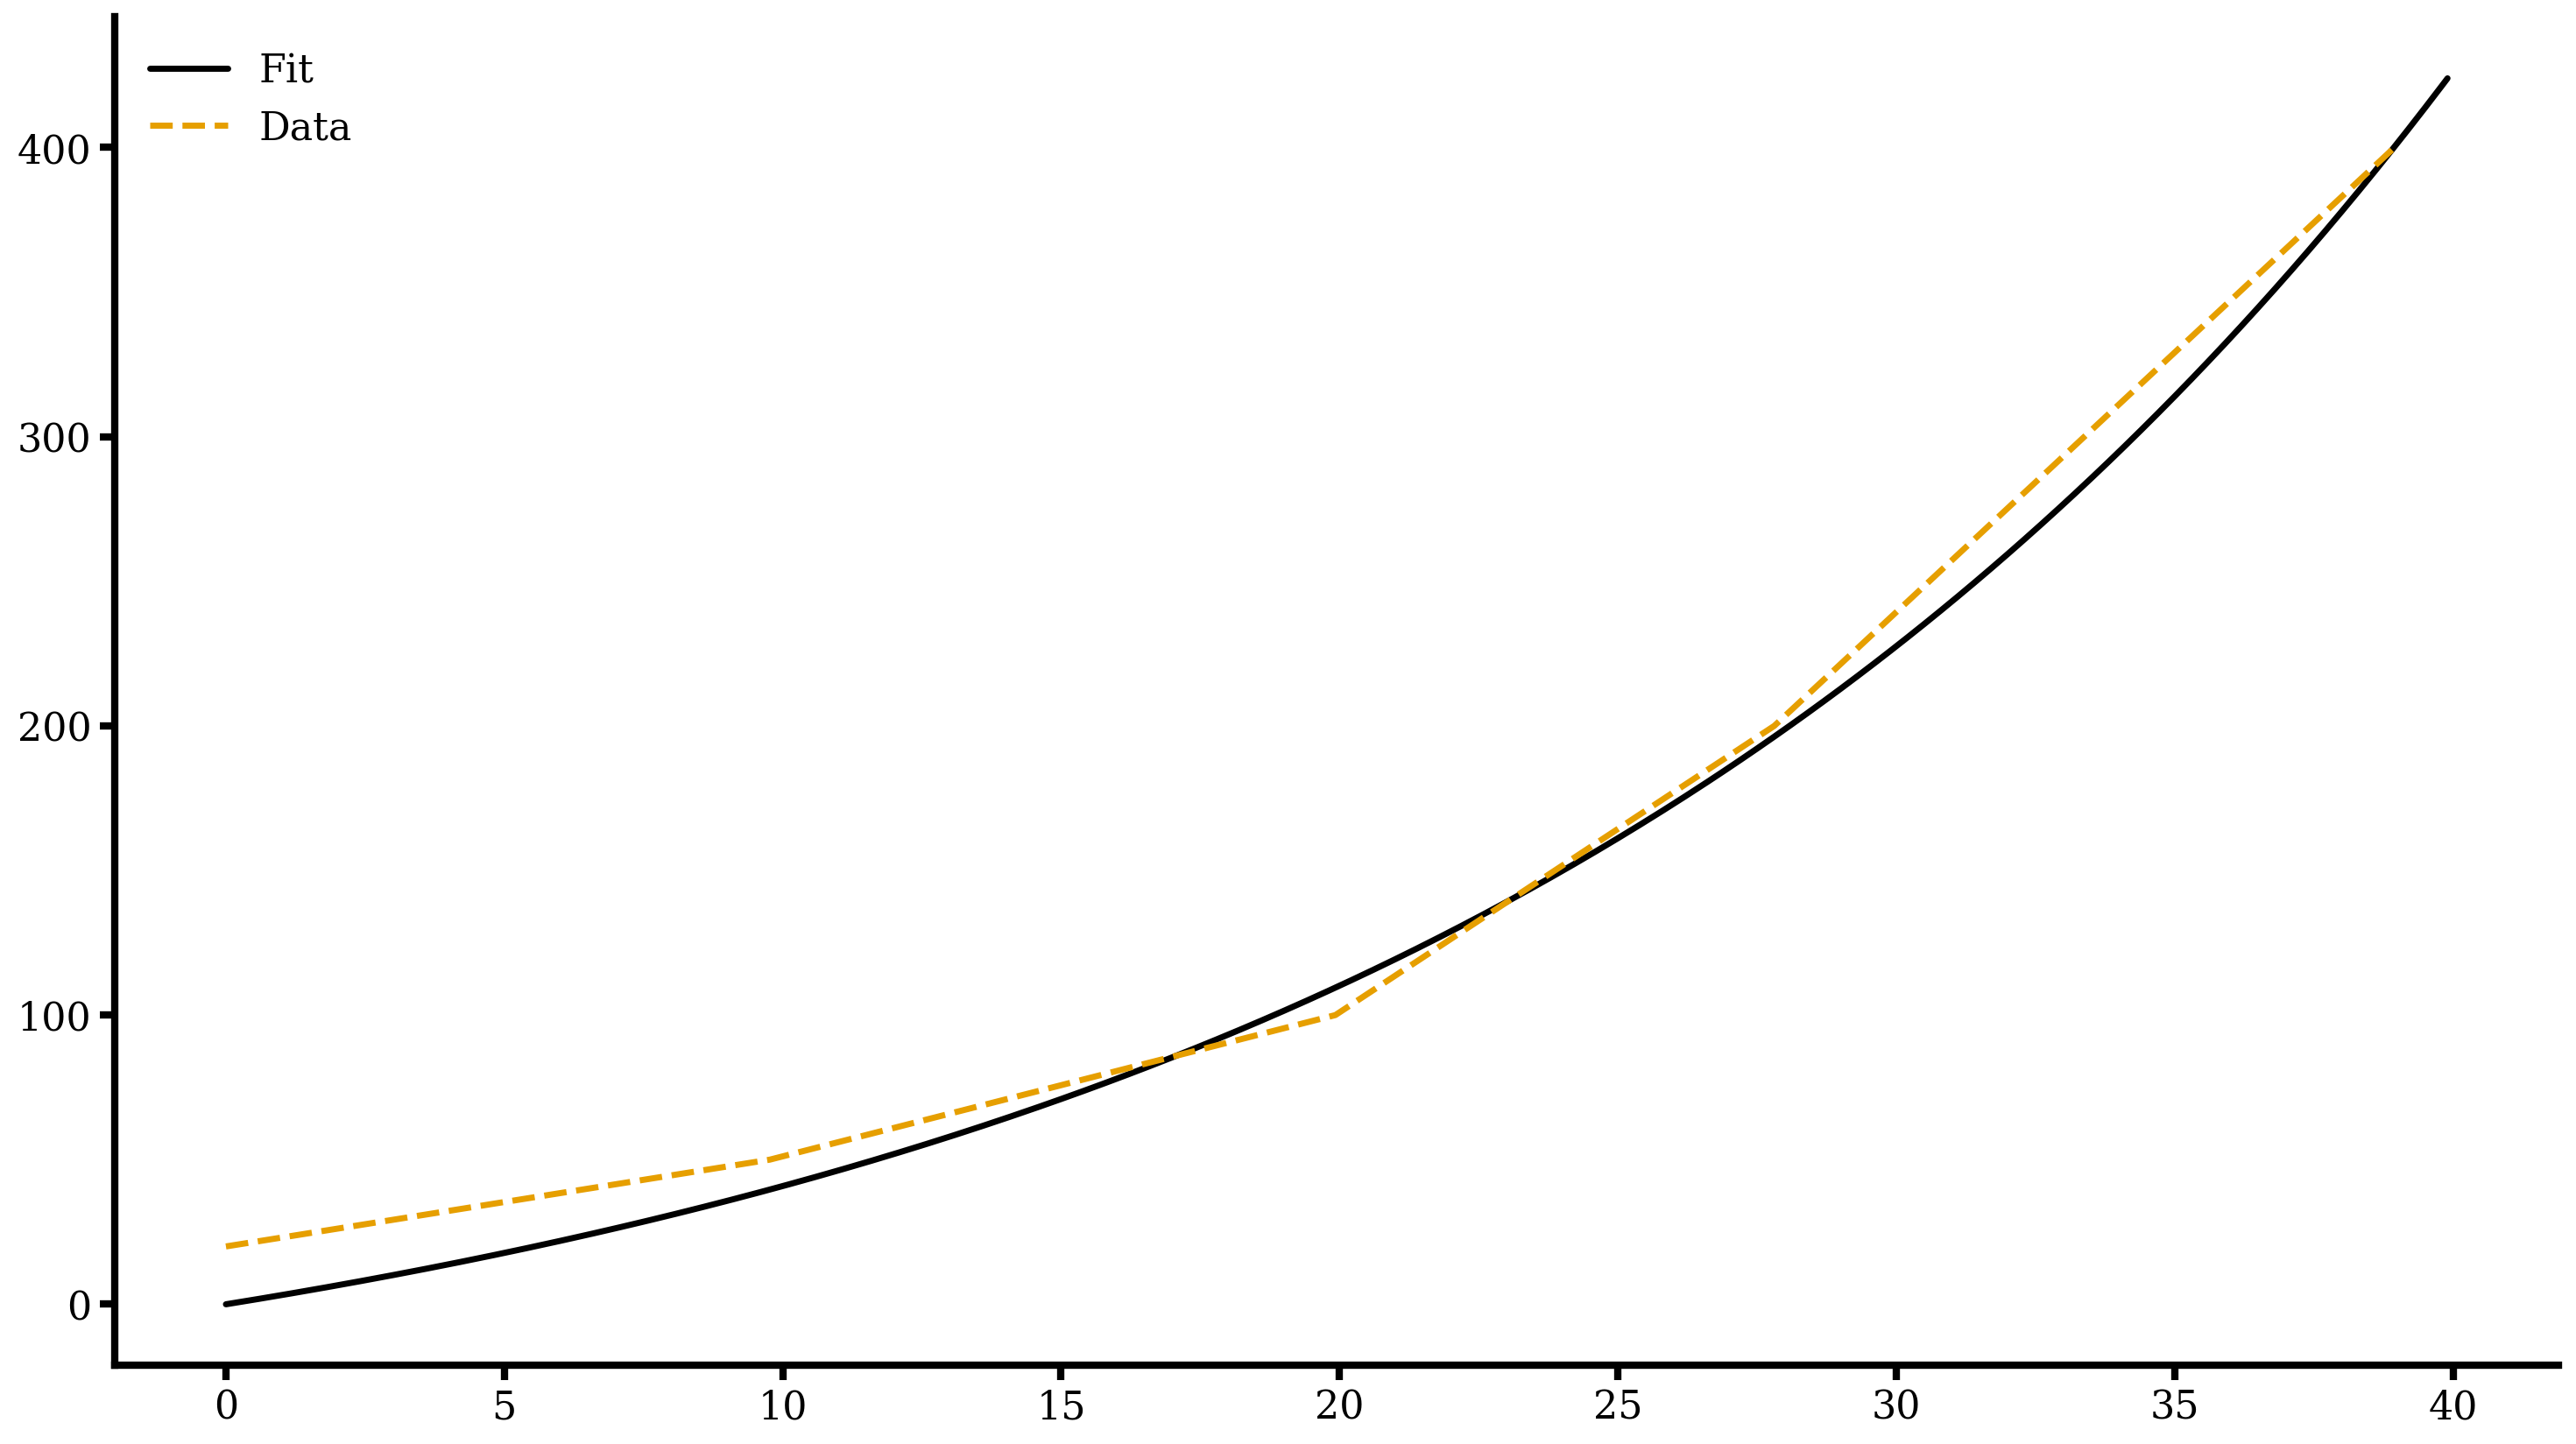

In [6]:
from scipy.optimize import curve_fit

# perform curve fit
def f(x, a, b):
    return a * (np.exp(x*b) - 1)

opt_fit = curve_fit(f, accumulated_mit_pot, costs)

# extract coefficient and power, respectively
ae,be = opt_fit[0]

# check plot
x_accumulated_pot = np.arange(0, 40, 0.1)
plt.plot(x_accumulated_pot, ae * (np.exp(x_accumulated_pot*be) - 1), label="Fit") # fit
plt.plot(accumulated_mit_pot, costs, label="Data") # data
plt.legend()

## Which curve do we go with?

The exponential fits the data better than the power law, and scales up faster at high mitigation potentials, which is expected to be how the real world works. So, based on our understanding of how costs scale up, we go with the exponential curve.

## Make cost bar figure (McKinsey-esque for AR6 WGIII data)

Basic strategy is to line up all the abatement amounts on the _x_-axis and the cost on the _y_-axis, sequenced by cost.

We're going through mitigation potentials for lifetime cost equal to  20
We're going through mitigation potentials for lifetime cost equal to  50
We're going through mitigation potentials for lifetime cost equal to  100
We're going through mitigation potentials for lifetime cost equal to  200
We're going through mitigation potentials for lifetime cost equal to  400


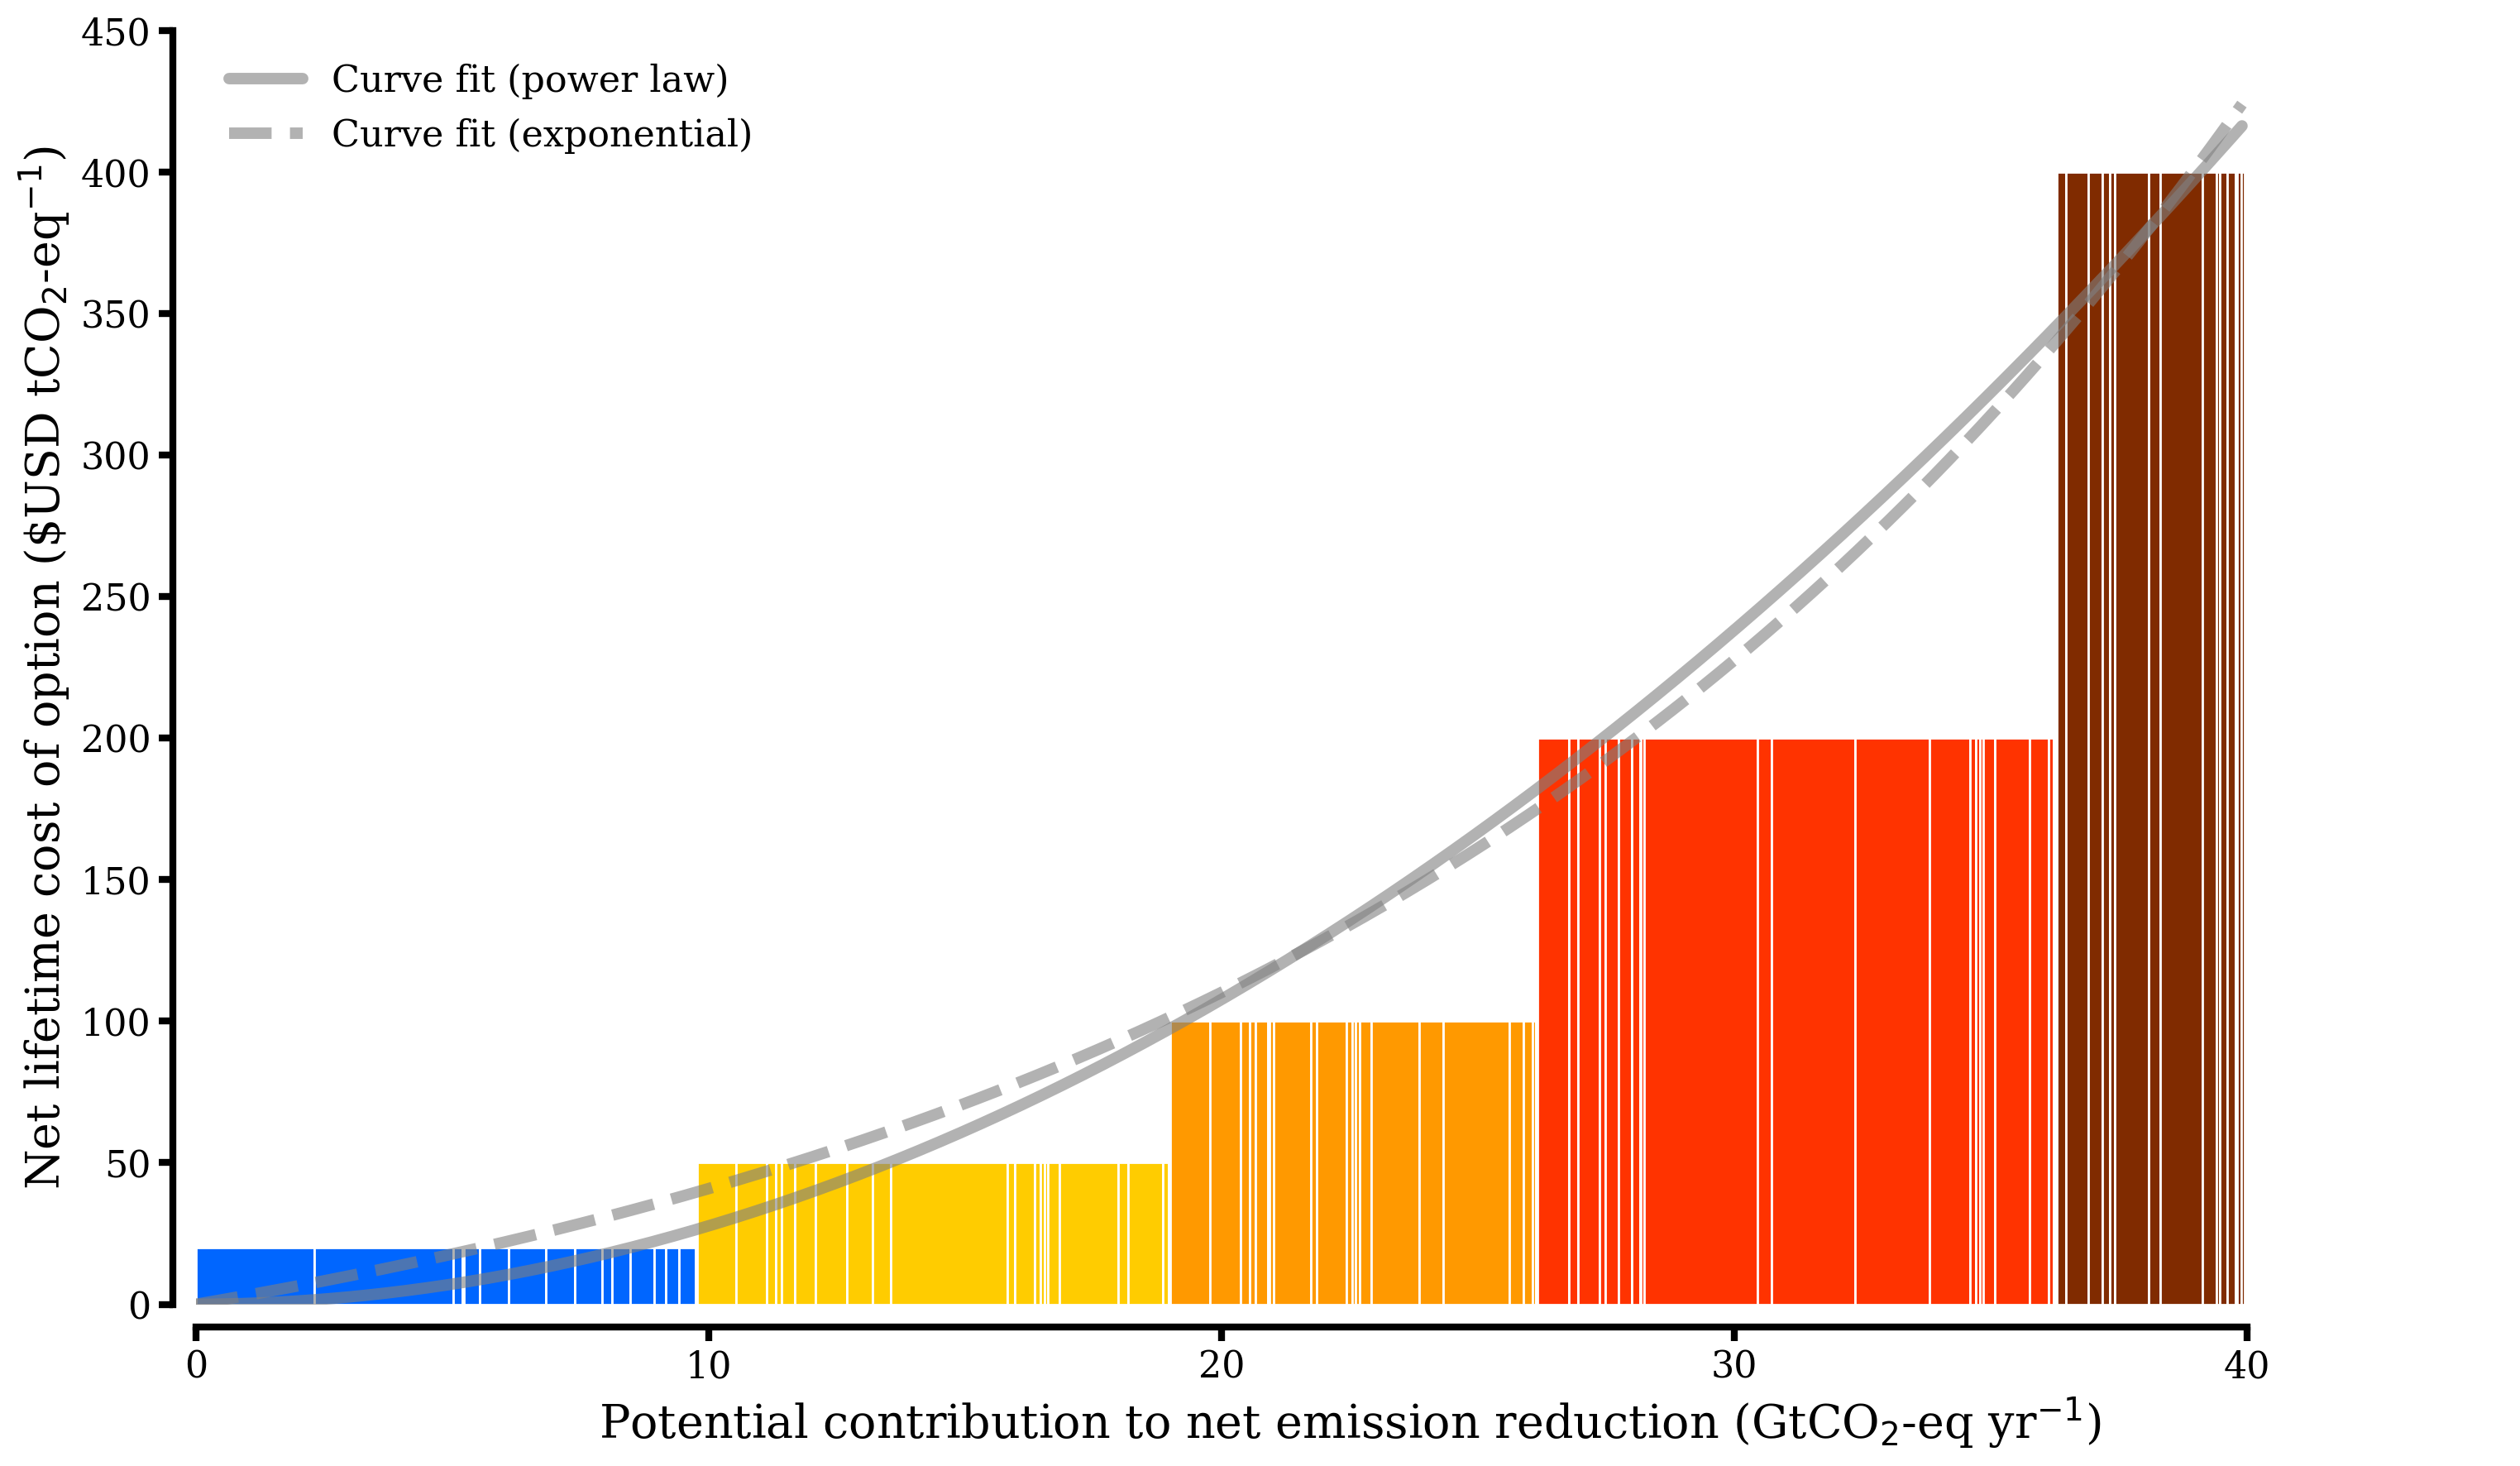

In [7]:
fig, ax = plt.subplots(1)

###################
# BAR CHART
###################
tot_mit_pot_plotted = 0
cost_brackets = [20, 50, 100, 200, 400]
bar_colors = ['#0066ff', '#ffcc00', '#ff9900', '#ff3300', '#802b00']
label_tracker = reset_label_tracker()

# ad hoc tilting of label lines based on eye, per cost bracket
# i did this by counting the number of labels in each cost bracket and tilting them by eye
tilt = -0.5
tilts =[
    [0, 0, tilt * 1.3, tilt * 1.2, tilt, tilt/1.2, tilt/1.5, tilt/3, tilt/-4, tilt/-2, -tilt, -tilt],
    [tilt, tilt*0.5, 0, 0, 0, 0, tilt, 0, 0, tilt/3, 0],
    [0,0,0,0],
    [0, tilt*0.5, 0, 0, 0, 0, 0],
    [tilt, tilt/2, tilt/-4, -tilt]
]

for cost_bracket in range(len(cost_brackets)):
    print("We're going through mitigation potentials for lifetime cost equal to ", cost_brackets[cost_bracket])
    vertical_shift = 2
    tilt_number = 0
    for key in cost_data:
        tmp_potential = cost_data[key][cost_bracket]
        if tmp_potential != 0:
            tmp_cost = cost_brackets[cost_bracket]
            
            # if cost = 0, make height small so it's still visible
            if tmp_cost == 0:
                tmp_cost += 3
                
            # make rectangle patch and add to axis
            tmp_bar = mpl.patches.Rectangle([tot_mit_pot_plotted, 0], tmp_potential, tmp_cost, 
                                           facecolor=bar_colors[cost_bracket], edgecolor='w')
            ax.add_patch(tmp_bar)
            
            # if mitigation potential is the maximum value for the given source,
            # put text label over it (avoids clutter)
            if tmp_potential == max(cost_data[key]) and label_tracker[key] == False:
                text_location = tot_mit_pot_plotted + tmp_potential/2.
                #if cost_brackets[cost_bracket] == 200:
                    #ax.plot([text_location, text_location + tilts[cost_bracket][tilt_number]], 
                    #    [tmp_cost + 1, tmp_cost + vertical_shift * 1.5],
                    #   color = 'k', linestyle='solid', linewidth=0.5)
                    #ax.text(text_location-0.1+tilts[cost_bracket][tilt_number], 
                    #        tmp_cost + vertical_shift * 1.5 + 3, str(key), 
                    #        rotation='horizontal', fontsize=10, fontweight='bold')
                #else:
                    #ax.plot([text_location, text_location + tilts[cost_bracket][tilt_number]], 
                    #    [tmp_cost + 1, tmp_cost + vertical_shift],
                    #   color = 'k', linestyle='solid', linewidth=0.5)
                    #ax.text(text_location-0.1+tilts[cost_bracket][tilt_number], 
                    #        tmp_cost + vertical_shift + 3, str(key), 
                    #        rotation='vertical', fontsize=10, fontweight='bold')
                label_tracker[key] = True
                vertical_shift += 8
                tilt_number += 1
            
            # increase total mitigation potential plotted to move anchor point of rectangle moving 
            # (see matplotlib.patches.Rectangle docs)
            tot_mit_pot_plotted += tmp_potential
            
###################
# CURVE FIT
###################
ax.plot(x_accumulated_pot, a * x_accumulated_pot**b, color='grey', 
        alpha=0.6, linewidth=5, zorder=1, label='Curve fit (power law)')

ax.plot(x_accumulated_pot, ae * (np.exp(x_accumulated_pot*be) - 1), color='grey', 
        alpha=0.6, linewidth=5, zorder=1, linestyle='dashed', label='Curve fit (exponential)')
ax.legend(loc='upper left')

###################
# COSMETICS
###################
ax.set_xlabel("Potential contribution to net emission reduction (GtCO$_2$-eq yr$^{-1}$)")
ax.set_ylabel("Net lifetime cost of option (\$USD tCO$_2$-eq$^{-1}$)")
ax.set_xlim(0,45)
ax.set_ylim(0,450)
ax.set_xticks([0,10,20,30,40])

sns.despine(trim=True, offset=10)

## Curve fits for individual SSPs 

Now we take the curve fit from the above and transform raw mitigation potential (in GtCO$_2$-eq yr$^{-1}$) to fraction of emissions abated, which is a unitless quantitiy.

In [8]:
# do you want to check the fits against the data?
check_plot = True

In [9]:
E_2030_ssp1 = 34.734424 # SSP1
E_2030_ssp2 = 43.476063 # SSP2
E_2030_ssp3 = 52.847359 # SSP3
E_2030_ssp4 = 45.167913 # SSP4
E_2030_ssp5 = 55.296583 # SSP5

frac_em_abated_ssp1 = accumulated_mit_pot * E_2030_ssp1**(-1)
frac_em_abated_ssp2 = accumulated_mit_pot * E_2030_ssp2**(-1)
frac_em_abated_ssp3 = accumulated_mit_pot * E_2030_ssp3**(-1)
frac_em_abated_ssp4 = accumulated_mit_pot * E_2030_ssp4**(-1)
frac_em_abated_ssp5 = accumulated_mit_pot * E_2030_ssp5**(-1)

In [10]:
def g(x, a, b):
    return a * x**b

opt_fit_ssp1p = curve_fit(g, frac_em_abated_ssp1+1e-2, costs)

SSP1:  58.86058226462219 1.831952215967607 
SSP2:  58.8605820424876 2.2930010323253702 
SSP3:  58.860582004738724 2.7872590206143646 
SSP4:  58.86058248081809 2.382232052452577 
SSP5:  58.860581972135996 2.916435234033552


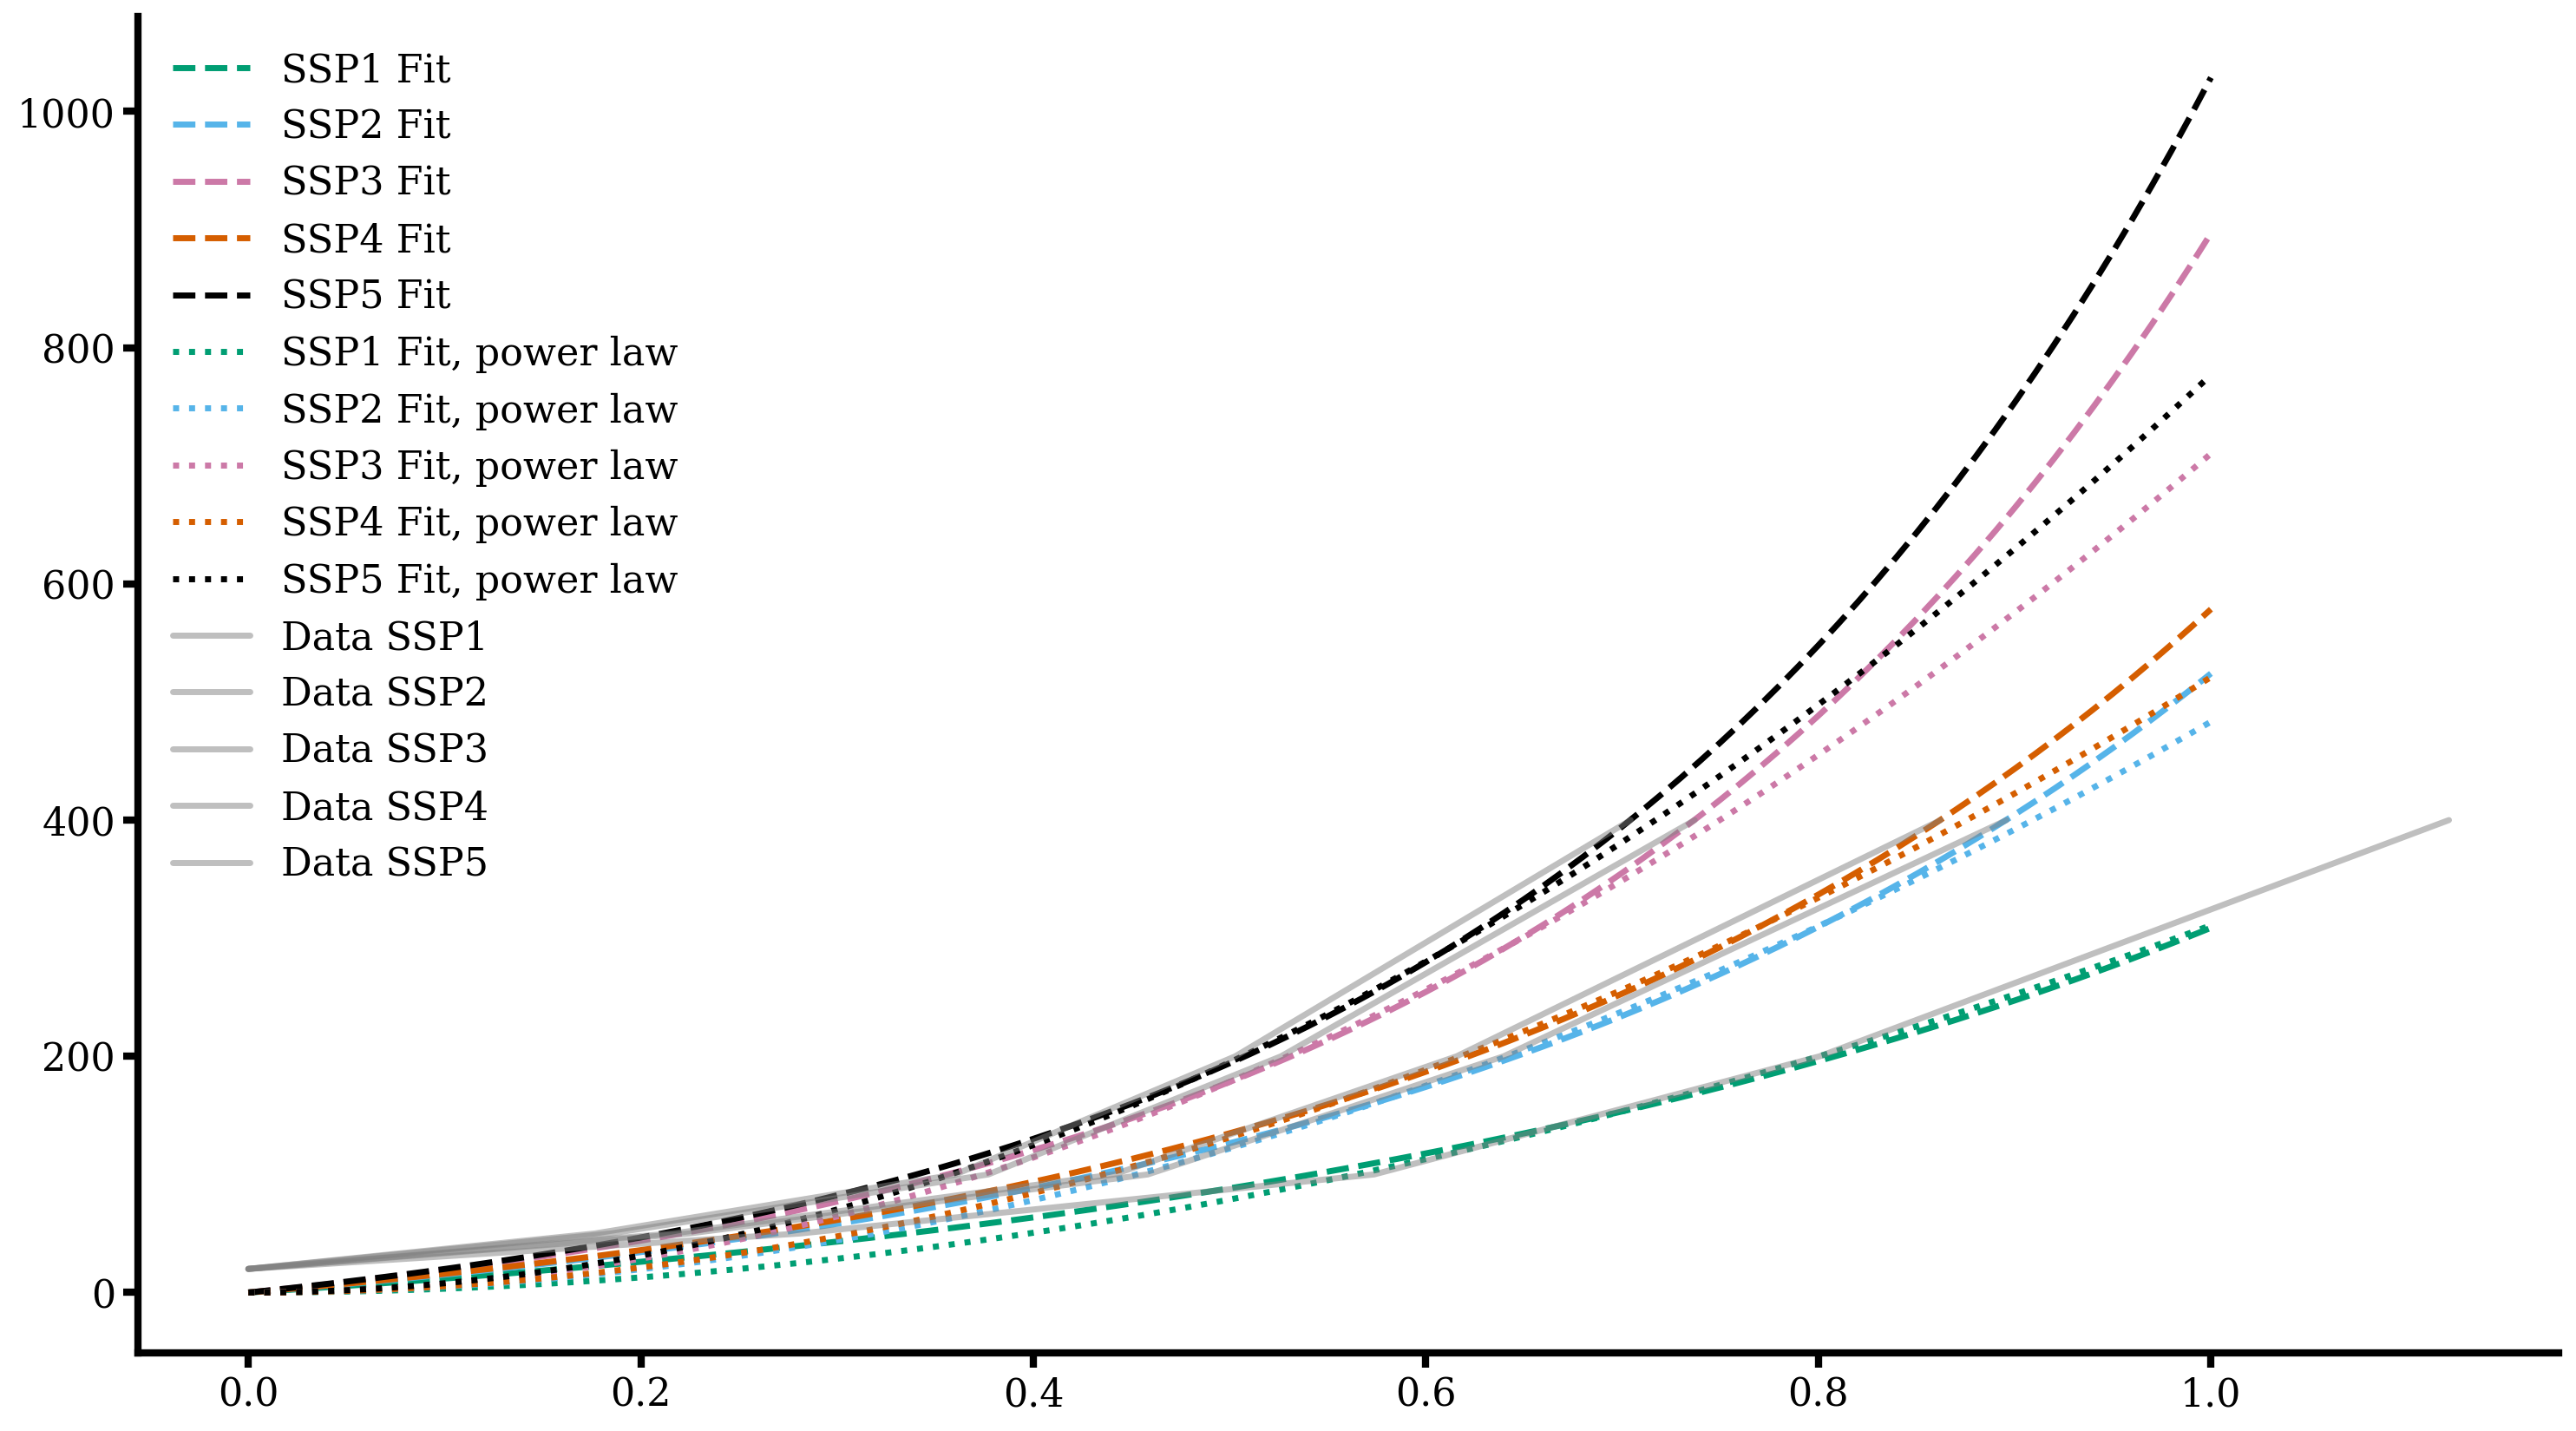

In [11]:
# perform curve fit
def f(x, a, b):
    return a * (np.exp(x*b) - 1)

def g(x, a, b):
    return a * x**b

opt_fit_ssp1 = curve_fit(f, frac_em_abated_ssp1, costs)
opt_fit_ssp2 = curve_fit(f, frac_em_abated_ssp2, costs)
opt_fit_ssp3 = curve_fit(f, frac_em_abated_ssp3, costs)
opt_fit_ssp4 = curve_fit(f, frac_em_abated_ssp4, costs)
opt_fit_ssp5 = curve_fit(f, frac_em_abated_ssp5, costs)

opt_fit_ssp1p = curve_fit(g, frac_em_abated_ssp1+1e-2, costs)
opt_fit_ssp2p = curve_fit(g, frac_em_abated_ssp2+1e-2, costs)
opt_fit_ssp3p = curve_fit(g, frac_em_abated_ssp3+1e-2, costs)
opt_fit_ssp4p = curve_fit(g, frac_em_abated_ssp4+1e-2, costs)
opt_fit_ssp5p = curve_fit(g, frac_em_abated_ssp5+1e-2, costs)

# extract coefficient and power, respectively
a_ssp1, b_ssp1 = opt_fit_ssp1[0]
a_ssp2, b_ssp2 = opt_fit_ssp2[0]
a_ssp3, b_ssp3 = opt_fit_ssp3[0]
a_ssp4, b_ssp4 = opt_fit_ssp4[0]
a_ssp5, b_ssp5 = opt_fit_ssp5[0]

print("SSP1: ", a_ssp1, b_ssp1, "\nSSP2: ",a_ssp2, b_ssp2, "\nSSP3: ",a_ssp3, b_ssp3, "\nSSP4: ", a_ssp4, b_ssp4, "\nSSP5: ",a_ssp5, b_ssp5)

ap_ssp1, bp_ssp1 = opt_fit_ssp1p[0]
ap_ssp2, bp_ssp2 = opt_fit_ssp2p[0]
ap_ssp3, bp_ssp3 = opt_fit_ssp3p[0]
ap_ssp4, bp_ssp4 = opt_fit_ssp4p[0]
ap_ssp5, bp_ssp5 = opt_fit_ssp5p[0]

# if you're interested... here's a check plot
frac_emis = np.arange(0, 1.01, 0.01)
if check_plot:
    color_list = ['#000000', '#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7']
    ssp5_cind = 0
    ssp4_cind = 6
    ssp3_cind = 7
    ssp2_cind = 2
    ssp1_cind = 3
    
    plt.plot(frac_emis, a_ssp1 * (np.exp(frac_emis * b_ssp1) - 1), label="SSP1 Fit", linestyle='dashed', color=color_list[ssp1_cind]) # fit
    plt.plot(frac_emis, a_ssp2 * (np.exp(frac_emis * b_ssp2) - 1), label="SSP2 Fit", linestyle='dashed', color=color_list[ssp2_cind]) # fit
    plt.plot(frac_emis, a_ssp3 * (np.exp(frac_emis * b_ssp3) - 1), label="SSP3 Fit", linestyle='dashed', color=color_list[ssp3_cind]) # fit
    plt.plot(frac_emis, a_ssp4 * (np.exp(frac_emis * b_ssp4) - 1), label="SSP4 Fit", linestyle='dashed', color=color_list[ssp4_cind]) # fit
    plt.plot(frac_emis, a_ssp5 * (np.exp(frac_emis * b_ssp5) - 1), label="SSP5 Fit", linestyle='dashed', color=color_list[ssp5_cind]) # fit
    
    plt.plot(frac_emis, ap_ssp1 * frac_emis**bp_ssp1, label="SSP1 Fit, power law", linestyle='dotted', color=color_list[ssp1_cind]) # fit
    plt.plot(frac_emis, ap_ssp2 * frac_emis**bp_ssp2, label="SSP2 Fit, power law", linestyle='dotted', color=color_list[ssp2_cind]) # fit
    plt.plot(frac_emis, ap_ssp3 * frac_emis**bp_ssp3, label="SSP3 Fit, power law", linestyle='dotted', color=color_list[ssp3_cind]) # fit
    plt.plot(frac_emis, ap_ssp4 * frac_emis**bp_ssp4, label="SSP4 Fit, power law", linestyle='dotted', color=color_list[ssp4_cind]) # fit
    plt.plot(frac_emis, ap_ssp5 * frac_emis**bp_ssp5, label="SSP5 Fit, power law", linestyle='dotted', color=color_list[ssp5_cind]) # fit

    plt.plot(accumulated_mit_pot * E_2030_ssp1**(-1), costs, label="Data SSP1", 
             linestyle='solid', color='grey', alpha=0.5) # data
    plt.plot(accumulated_mit_pot * E_2030_ssp2**(-1), costs, label="Data SSP2", 
             linestyle='solid', color='grey', alpha=0.5) # data
    plt.plot(accumulated_mit_pot * E_2030_ssp3**(-1), costs, label="Data SSP3", 
             linestyle='solid', color='grey', alpha=0.5) # data
    plt.plot(accumulated_mit_pot * E_2030_ssp4**(-1), costs, label="Data SSP4", 
             linestyle='solid', color='grey', alpha=0.5) # data
    plt.plot(accumulated_mit_pot * E_2030_ssp5**(-1), costs, label="Data SSP5", 
             linestyle='solid', color='grey', alpha=0.5) # data
    plt.legend()

## Total cost to society curves

After doing a derivation you can plot the fraction of consumption required to pay the tax. If $\tau(x) = \tau_{0}\left( e^{\xi x} - 1\right)$, then
$$
\kappa(x) = \dfrac{E_{0}\tau_{0}}{c_{2020}} \left( \dfrac{e^{\xi x} - 1}{\xi} - x\right)
$$

0.06157416200064821 0.11924161225940128 0.22452334749060415 0.134304562858623 0.2625717564262483


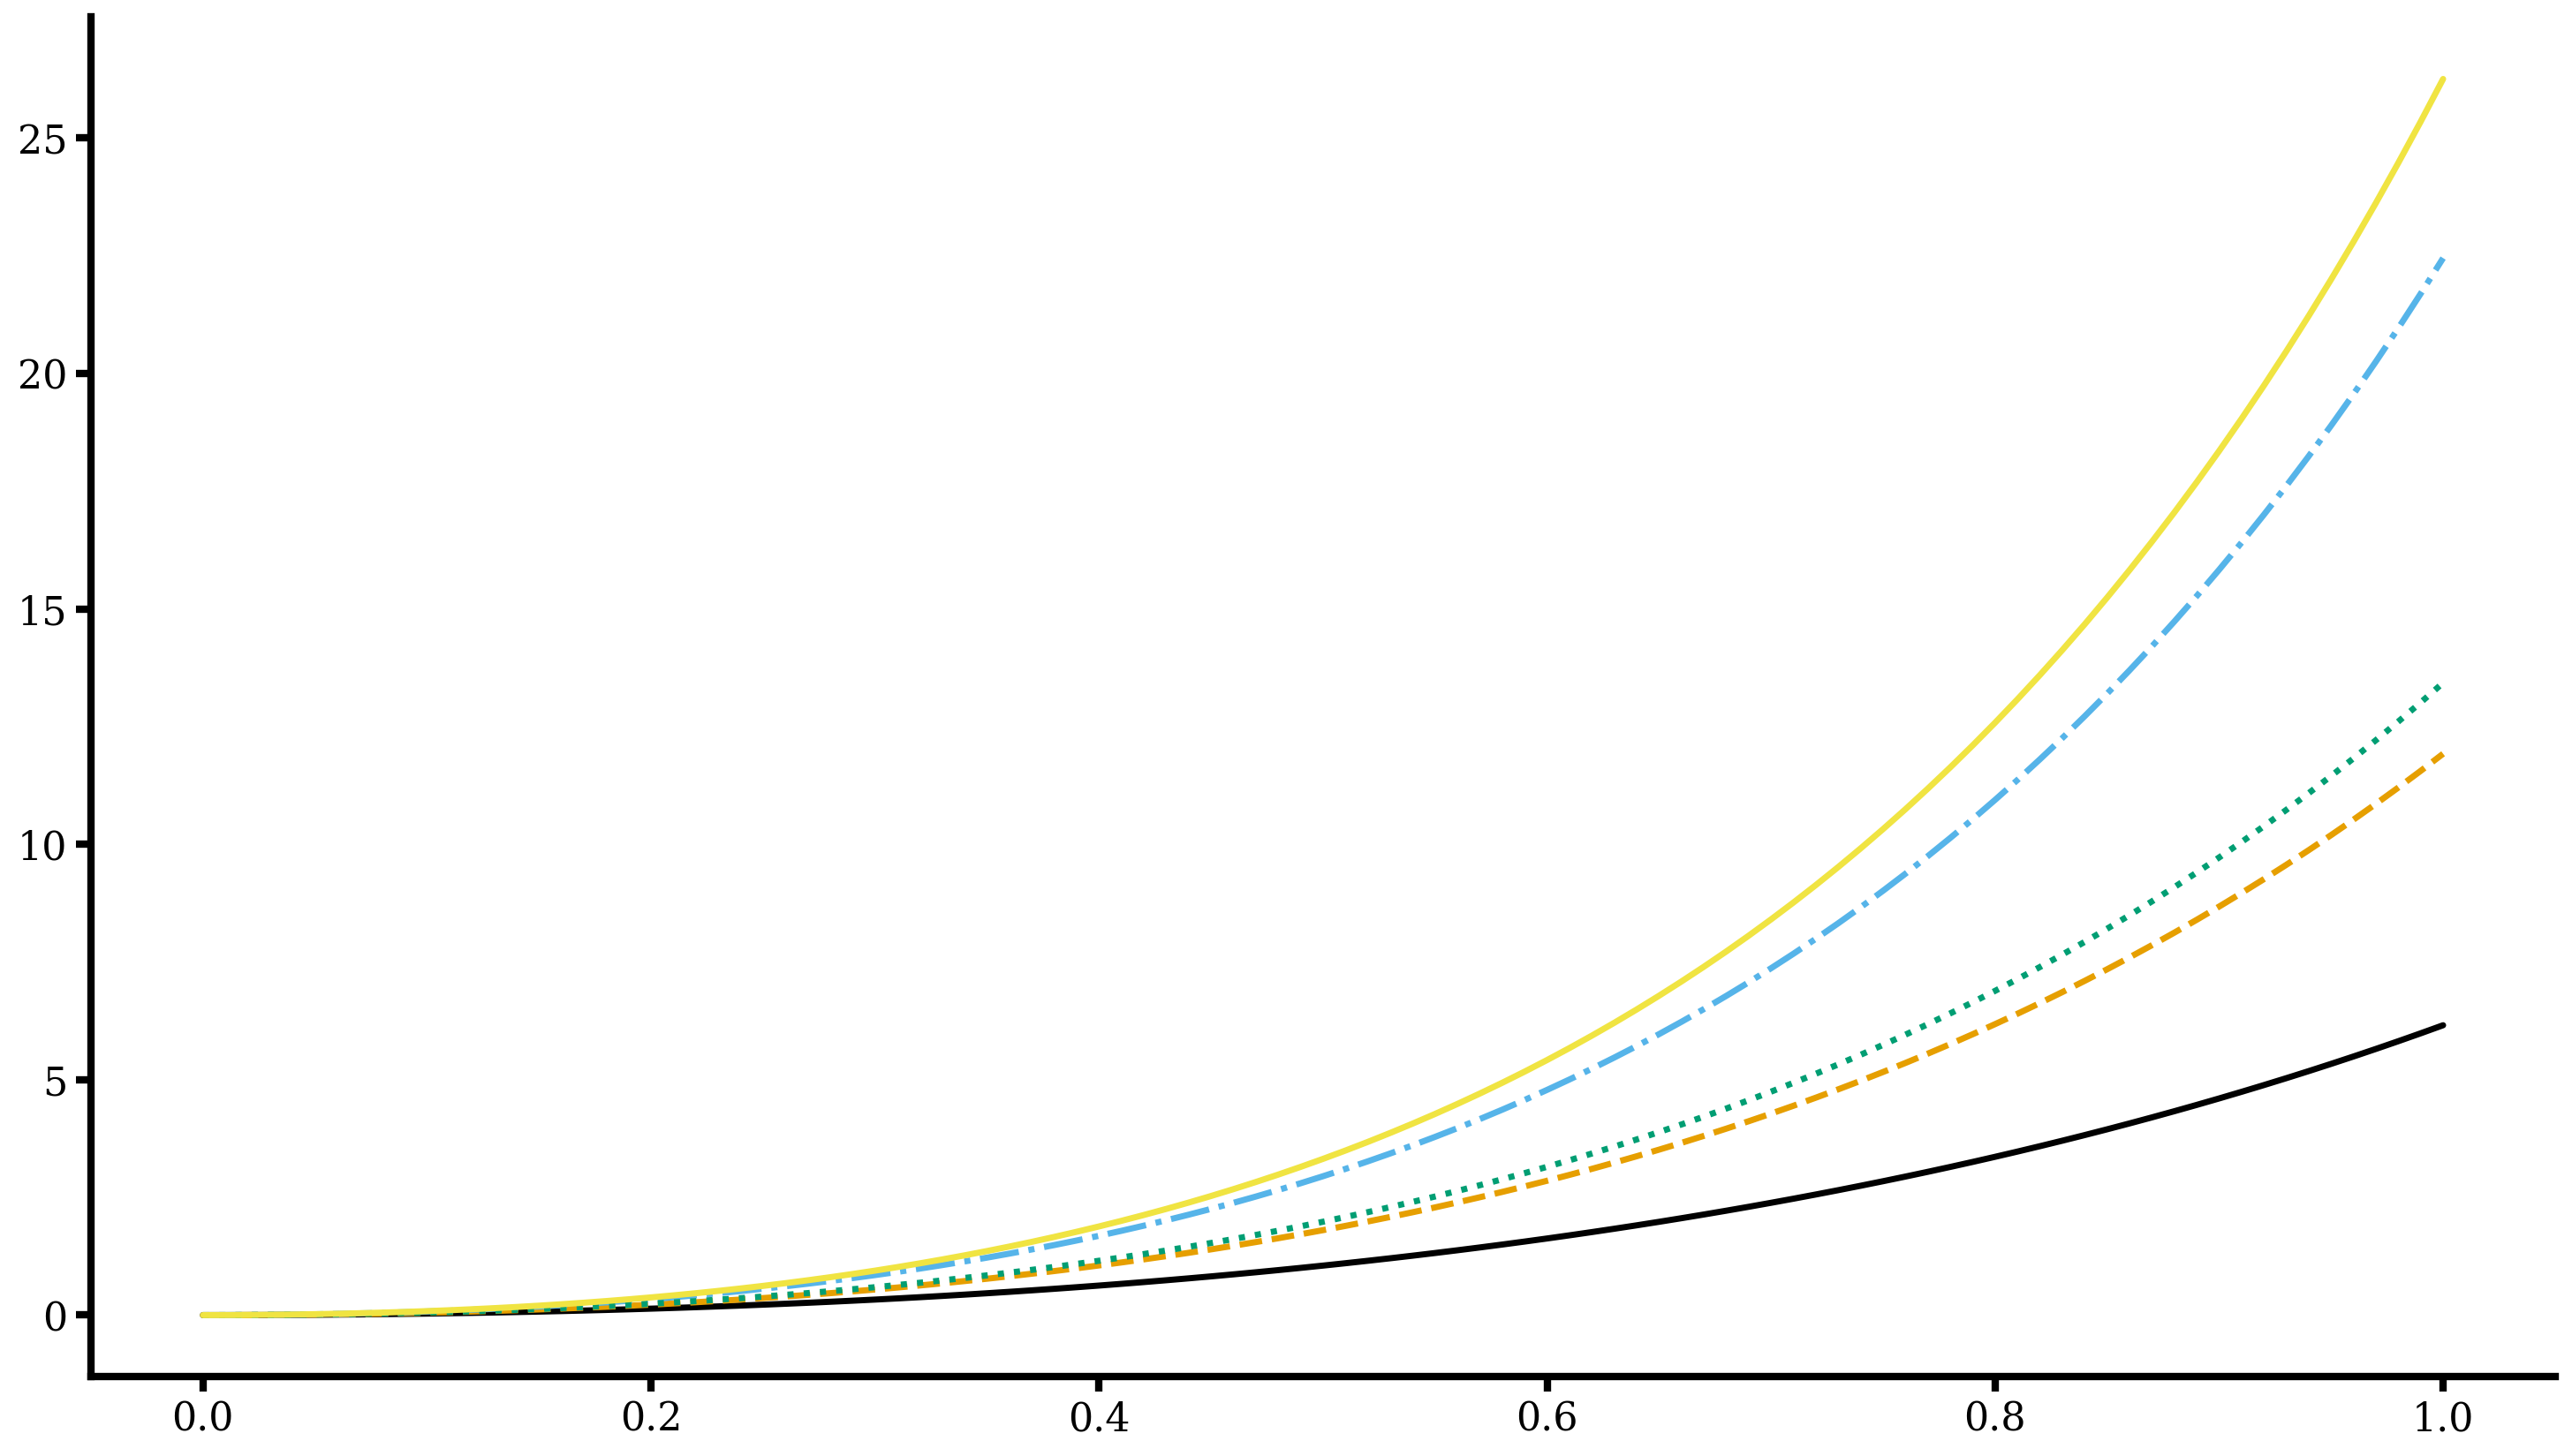

In [12]:
c2020 = 61880
frac_cost_ssp1 = E_2030_ssp1 * a_ssp1 * 61880**(-1) * (b_ssp1**(-1) * (np.exp(b_ssp1 * frac_emis) - 1) - frac_emis)
frac_cost_ssp2 = E_2030_ssp2 * a_ssp2 * 61880**(-1) * (b_ssp2**(-1) * (np.exp(b_ssp2 * frac_emis) - 1) - frac_emis)
frac_cost_ssp3 = E_2030_ssp3 * a_ssp3 * 61880**(-1) * (b_ssp3**(-1) * (np.exp(b_ssp3 * frac_emis) - 1) - frac_emis)
frac_cost_ssp4 = E_2030_ssp4 * a_ssp4 * 61880**(-1) * (b_ssp4**(-1) * (np.exp(b_ssp4 * frac_emis) - 1) - frac_emis)
frac_cost_ssp5 = E_2030_ssp5 * a_ssp5 * 61880**(-1) * (b_ssp5**(-1) * (np.exp(b_ssp5 * frac_emis) - 1) - frac_emis)

print(frac_cost_ssp1[-1], frac_cost_ssp2[-1], frac_cost_ssp3[-1], frac_cost_ssp4[-1], frac_cost_ssp5[-1],)

plt.plot(frac_emis, frac_cost_ssp1 * 100)
plt.plot(frac_emis, frac_cost_ssp2 * 100)
plt.plot(frac_emis, frac_cost_ssp3 * 100)
plt.plot(frac_emis, frac_cost_ssp4 * 100)
plt.plot(frac_emis, frac_cost_ssp5 * 100)

# Full Figure

We have three panels: McKinsey-esque figure, then subfigures with 2030 cost curves and 2100 cost curves.

In [18]:
# save your creation? 
save_fig = False

We're going through mitigation potentials for lifetime cost equal to  20
We're going through mitigation potentials for lifetime cost equal to  50
We're going through mitigation potentials for lifetime cost equal to  100
We're going through mitigation potentials for lifetime cost equal to  200
We're going through mitigation potentials for lifetime cost equal to  400


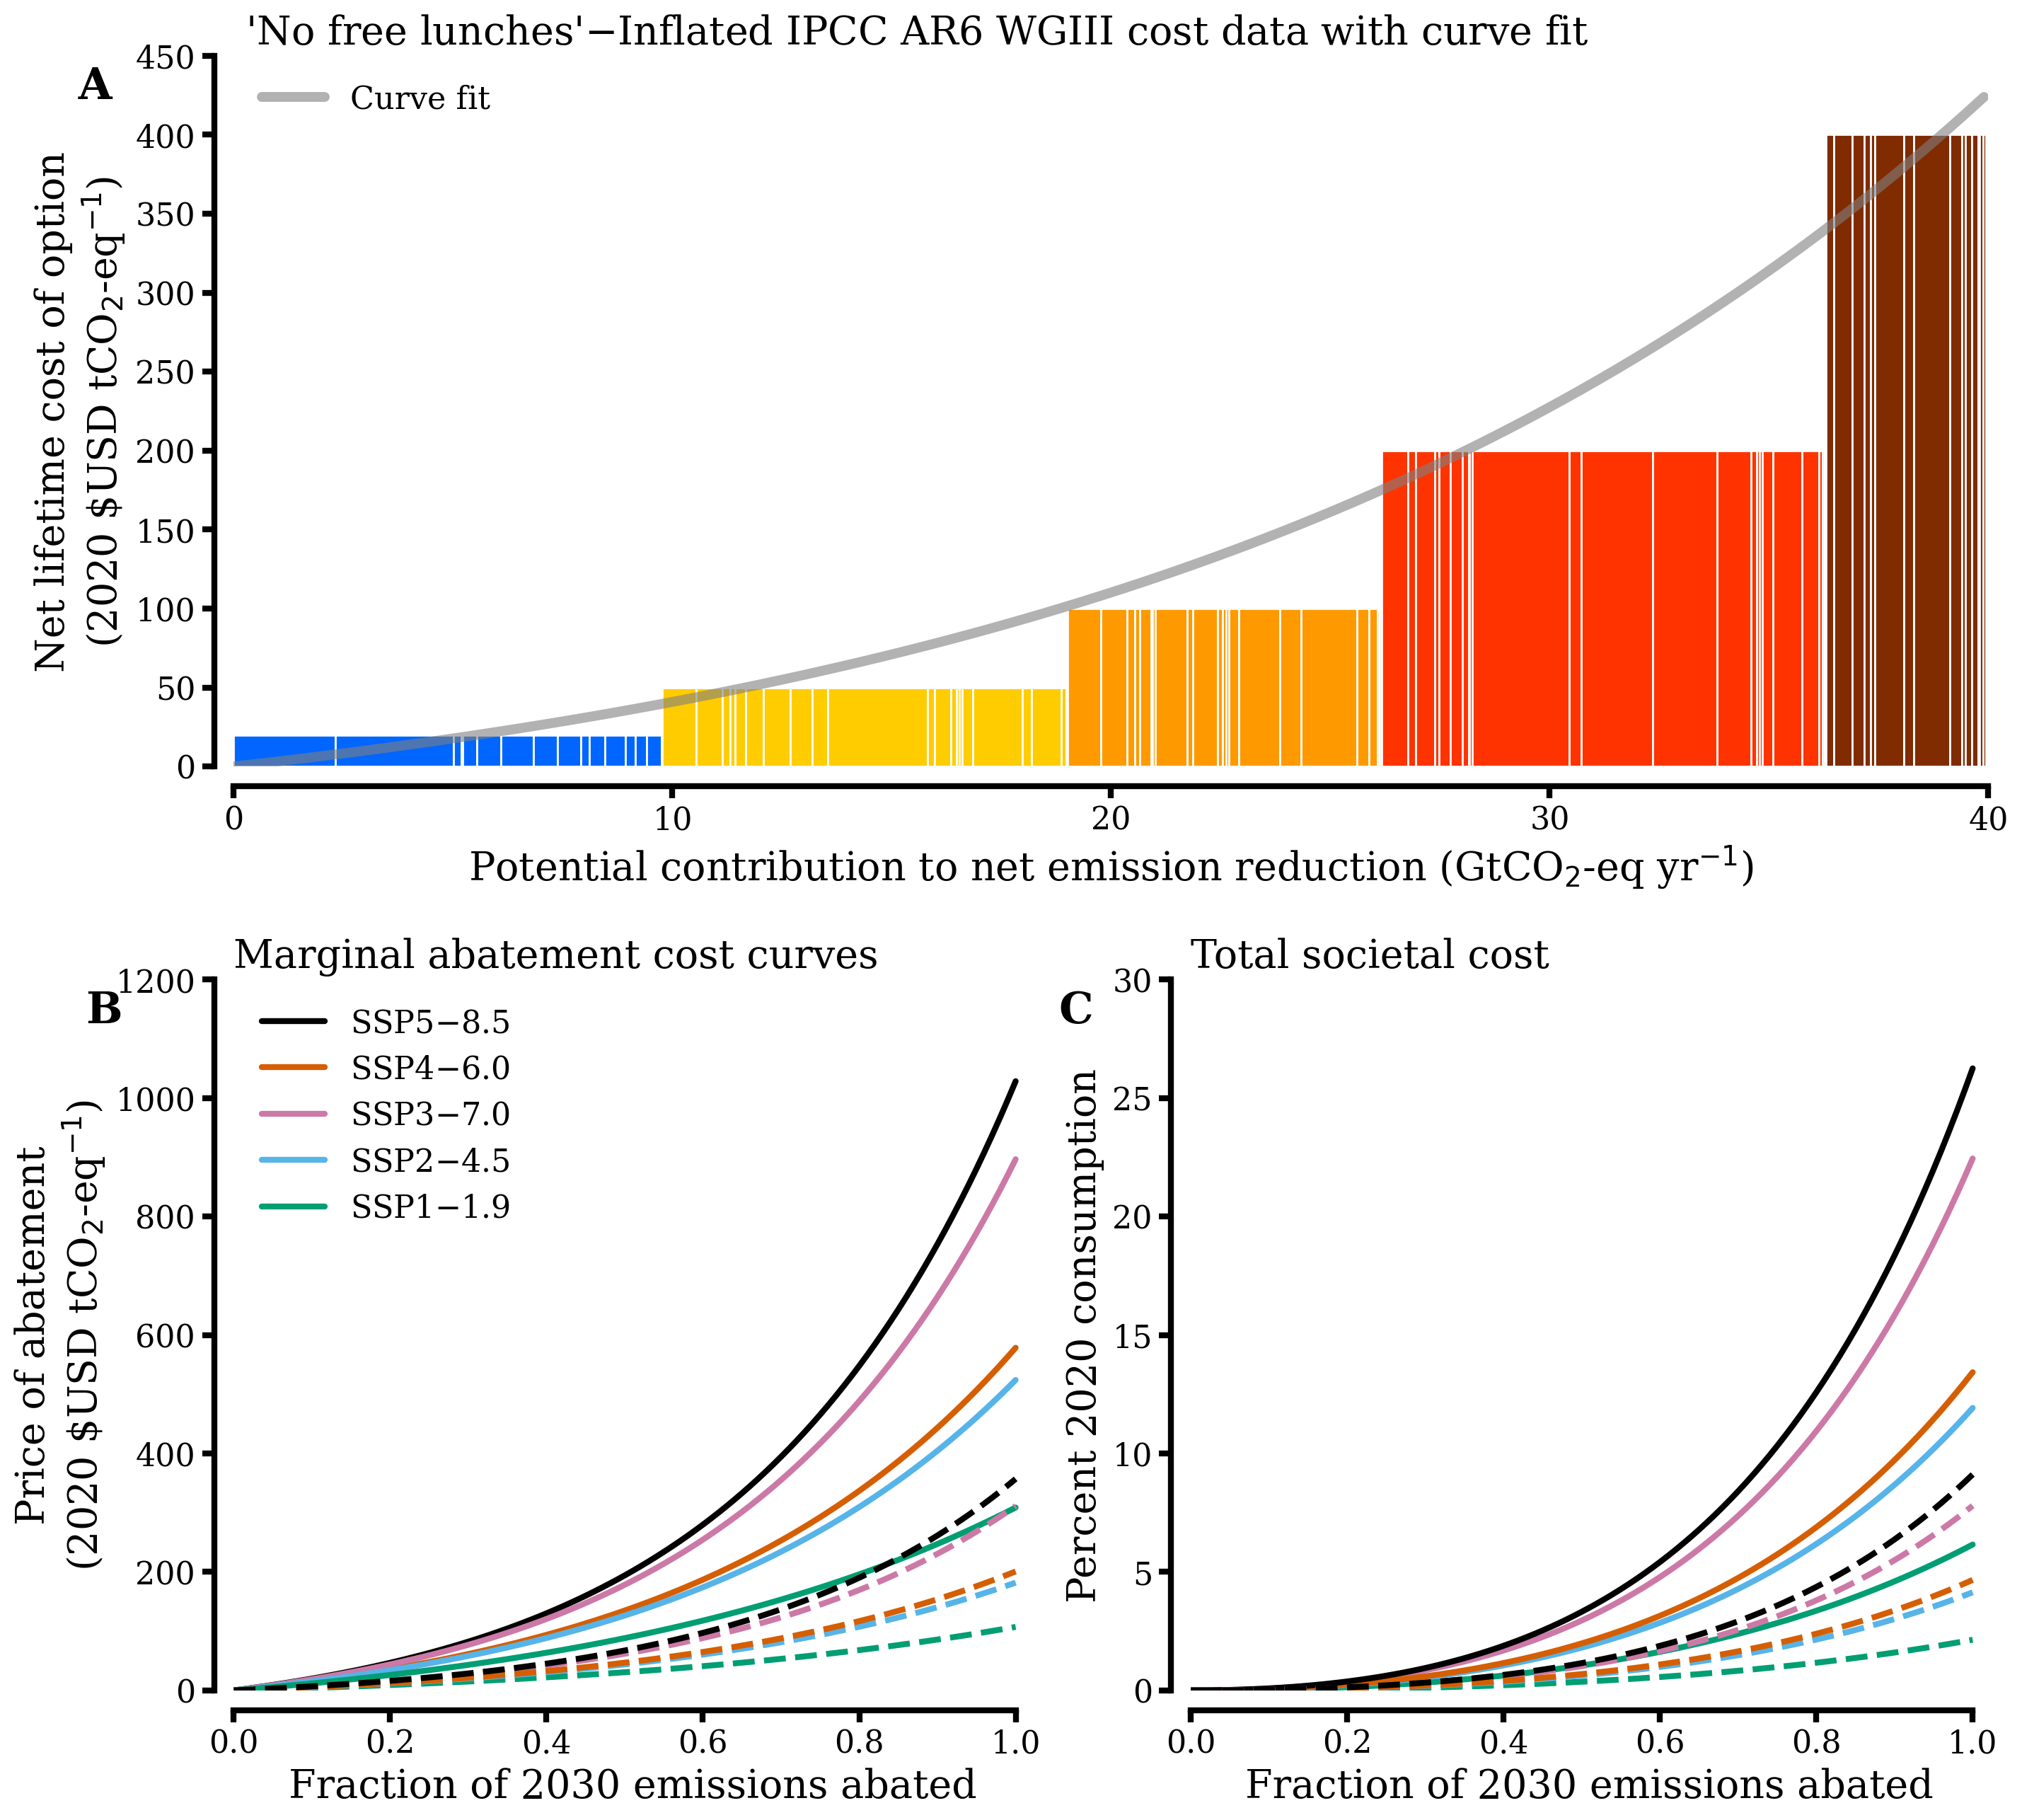

In [17]:
import matplotlib.transforms as mtransforms

mckinsey_row = ['A', 'A']
indiv_row = ['B', 'C']

fig, ax = plt.subplot_mosaic([mckinsey_row, indiv_row], sharex=False,
                             gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [0.38, 0.38]},
                            figsize=(16,15))

###################
# BAR CHART
###################
tot_mit_pot_plotted = 0
cost_brackets = [20, 50, 100, 200, 400]
bar_colors = ['#0066ff', '#ffcc00', '#ff9900', '#ff3300', '#802b00']
label_tracker = reset_label_tracker()

# ad hoc tilting of label lines based on eye, per cost bracket
# i did this by counting the number of labels in each cost bracket and tilting them by eye
tilt = -0.5
tilts =[
    [0, 0, tilt * 1.3, tilt * 1.2, tilt, tilt/1.2, tilt/1.5, tilt/3, tilt/-4, tilt/-2, -tilt, -tilt],
    [tilt*1.5, tilt*0.5, 0, 0, 0, 0, tilt, 0, 0, tilt/3, 0],
    [0,0,0,0],
    [tilt, tilt*0.9, 0, 0, 0, 0, tilt*0.8],
    [4.6 * tilt, 5.75 * tilt, 6.4 * tilt, 6.8 * tilt]
]

for cost_bracket in range(len(cost_brackets)):
    print("We're going through mitigation potentials for lifetime cost equal to ", cost_brackets[cost_bracket])
    vertical_shift = 4
    tilt_number = 0
    for key in cost_data:
        tmp_potential = cost_data[key][cost_bracket]
        if tmp_potential != 0:
            tmp_cost = cost_brackets[cost_bracket]
            
            # if cost = 0, make height small so it's still visible
            if tmp_cost == 0:
                tmp_cost += 3
                
            # make rectangle patch and add to axis
            tmp_bar = mpl.patches.Rectangle([tot_mit_pot_plotted, 0], tmp_potential, tmp_cost, 
                                           facecolor=bar_colors[cost_bracket], edgecolor='w')
            ax['A'].add_patch(tmp_bar)
            
            # if mitigation potential is the maximum value for the given source,
            # put text label over it (avoids clutter)
            if tmp_potential == max(cost_data[key]) and label_tracker[key] == False:
                text_location = tot_mit_pot_plotted + tmp_potential/2.
                """
                if cost_brackets[cost_bracket] == 200:
                    ax['A'].plot([text_location, text_location + tilts[cost_bracket][tilt_number]/2.], 
                        [tmp_cost + 1, tmp_cost + vertical_shift * 3],
                       color = 'k', linestyle='solid', linewidth=0.5)
                    ax['A'].text(text_location-0.1+tilts[cost_bracket][tilt_number], 
                            tmp_cost + vertical_shift * 3 + 3, str(key), 
                            rotation='horizontal', fontsize=10)
                else:
                    ax['A'].plot([text_location, text_location + tilts[cost_bracket][tilt_number]], 
                        [tmp_cost + 1, tmp_cost + vertical_shift],
                       color = 'k', linestyle='solid', linewidth=0.5)
                    ax['A'].text(text_location-0.1+tilts[cost_bracket][tilt_number], 
                            tmp_cost + vertical_shift + 3, str(key), 
                            rotation='vertical', fontsize=10)
                """
                label_tracker[key] = True
                vertical_shift += 8
                tilt_number += 1
            
            # increase total mitigation potential plotted to move anchor point of rectangle moving 
            # (see matplotlib.patches.Rectangle docs)
            tot_mit_pot_plotted += tmp_potential
            
###################
# CURVE FIT
###################
ax['A'].plot(x_accumulated_pot, ae * (np.exp(x_accumulated_pot*be) - 1), color='grey', 
        alpha=0.6, linewidth=5, zorder=1, linestyle='solid', label='Curve fit')
ax['A'].legend(loc='upper left')

###################
# COSMETICS
###################
ax['A'].set_xlabel("Potential contribution to net emission reduction (GtCO$_2$-eq yr$^{-1}$)")
ax['A'].set_ylabel("Net lifetime cost of option\n(2020 \$USD tCO$_2$-eq$^{-1}$)")
ax['A'].set_xlim(0,40)
ax['A'].set_ylim(0,450)
ax['A'].set_xticks([0,10,20,30,40])
ax['A'].set_title(" 'No free lunches'$-$Inflated IPCC AR6 WGIII cost data with curve fit")

###################
# 2030 COST CURVES
###################
color_list = ['#000000', '#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7']
ssp5_cind = 0
ssp4_cind = 6
ssp3_cind = 7
ssp2_cind = 2
ssp1_cind = 3

ax['B'].plot(frac_emis, a_ssp5 * (np.exp(frac_emis * b_ssp5) - 1), label="SSP5$-$8.5", 
             color=color_list[ssp5_cind], linestyle='solid', linewidth=3) # fit
ax['B'].plot(frac_emis, a_ssp4 * (np.exp(frac_emis * b_ssp4) - 1), label="SSP4$-$6.0", 
             color=color_list[ssp4_cind], linestyle='solid', linewidth=3) # fit
ax['B'].plot(frac_emis, a_ssp3 * (np.exp(frac_emis * b_ssp3) - 1), label="SSP3$-$7.0", 
             color=color_list[ssp3_cind], linestyle='solid', linewidth=3) # fit
ax['B'].plot(frac_emis, a_ssp2 * (np.exp(frac_emis * b_ssp2) - 1), label="SSP2$-$4.5", 
             color=color_list[ssp2_cind], linestyle='solid', linewidth=3) # fit
ax['B'].plot(frac_emis, a_ssp1 * (np.exp(frac_emis * b_ssp1) - 1), label="SSP1$-$1.9", 
             color=color_list[ssp1_cind], linestyle='solid', linewidth=3) # fit

ax['B'].plot(frac_emis, (1 - 0.015)**(70) * a_ssp1 * (np.exp(frac_emis * b_ssp1) - 1), 
             color=color_list[ssp1_cind], linestyle='dashed', linewidth=3) # fit
ax['B'].plot(frac_emis, (1 - 0.015)**(70) * a_ssp2 * (np.exp(frac_emis * b_ssp2) - 1), 
             color=color_list[ssp2_cind], linestyle='dashed', linewidth=3) # fit
ax['B'].plot(frac_emis, (1 - 0.015)**(70) * a_ssp3 * (np.exp(frac_emis * b_ssp3) - 1), 
             color=color_list[ssp3_cind], linestyle='dashed', linewidth=3) # fit
ax['B'].plot(frac_emis, (1 - 0.015)**(70) * a_ssp4 * (np.exp(frac_emis * b_ssp4) - 1), 
             color=color_list[ssp4_cind], linestyle='dashed', linewidth=3) # fit
ax['B'].plot(frac_emis, (1 - 0.015)**(70) * a_ssp5 * (np.exp(frac_emis * b_ssp5) - 1), 
             color=color_list[ssp5_cind], linestyle='dashed', linewidth=3) # fit

ax['B'].set_xlim(0,1.02)
ax['B'].set_ylim(0,1200)
ax['B'].set_title("Marginal abatement cost curves")
ax['B'].set_xlabel("Fraction of 2030 emissions abated")
ax['B'].set_ylabel("Price of abatement\n(2020 \$USD tCO$_2$-eq$^{-1}$)")
ax['B'].legend()

###################
# 2100 COST CURVES
###################
ax['C'].plot(frac_emis, frac_cost_ssp1 * 100,
             color=color_list[ssp1_cind], linestyle='solid', linewidth=3) # fit
ax['C'].plot(frac_emis, frac_cost_ssp2 * 100, 
             color=color_list[ssp2_cind], linestyle='solid', linewidth=3) # fit
ax['C'].plot(frac_emis, frac_cost_ssp3 * 100, 
             color=color_list[ssp3_cind], linestyle='solid', linewidth=3) # fit
ax['C'].plot(frac_emis, frac_cost_ssp4 * 100, 
             color=color_list[ssp4_cind], linestyle='solid', linewidth=3) # fit
ax['C'].plot(frac_emis, frac_cost_ssp5 * 100,
             color=color_list[ssp5_cind], linestyle='solid', linewidth=3) # fit

ax['C'].plot(frac_emis, (1 - 0.015)**70 * frac_cost_ssp1 * 100,
             color=color_list[ssp1_cind], linestyle='dashed', linewidth=3) # fit
ax['C'].plot(frac_emis, (1 - 0.015)**70 * frac_cost_ssp2 * 100, 
             color=color_list[ssp2_cind], linestyle='dashed', linewidth=3) # fit
ax['C'].plot(frac_emis, (1 - 0.015)**70 * frac_cost_ssp3 * 100,
             color=color_list[ssp3_cind], linestyle='dashed', linewidth=3) # fit
ax['C'].plot(frac_emis, (1 - 0.015)**70 * frac_cost_ssp4 * 100,
             color=color_list[ssp4_cind], linestyle='dashed', linewidth=3) # fit
ax['C'].plot(frac_emis, (1 - 0.015)**70 * frac_cost_ssp5 * 100, 
             color=color_list[ssp5_cind], linestyle='dashed', linewidth=3) # fit
ax['C'].set_xlim(0,1.02)
ax['C'].set_ylim(0,30)
ax['C'].set_title("Total societal cost")
ax['C'].set_xlabel("Fraction of 2030 emissions abated")
ax['C'].set_ylabel("Percent 2020 consumption")
#ax['C'].set_yticklabels([])

for label in mckinsey_row:
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax[label].text(-0.1, 1, label, transform=ax[label].transAxes + trans,
             fontsize=22, fontweight='bold',
            verticalalignment='top', bbox=dict(facecolor='none', edgecolor='none', pad=1))
    
for label in indiv_row[0]:
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax[label].text(-0.21, 1, label, transform=ax[label].transAxes + trans,
             fontsize=22, fontweight='bold',
            verticalalignment='top', bbox=dict(facecolor='none', edgecolor='none', pad=1))
    
for label in indiv_row[1]:
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax[label].text(-0.19, 1, label, transform=ax[label].transAxes + trans,
             fontsize=22, fontweight='bold',
            verticalalignment='top', bbox=dict(facecolor='none', edgecolor='none', pad=1))
    
fig.subplots_adjust(hspace=0.3, wspace=0.2)
sns.despine(trim=True, offset=10)
if save_fig:
    fig.savefig(''.join([basefile, 'stacked_maccs_cost_NFL.png']), dpi=400)